In [1]:
import pandas as pd
import numpy as np

import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
import scipy.stats as ss
from scipy.stats import norm
from tqdm.auto import tqdm

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Содержание
### 0. Загрузка данных и предобработка
### 1.a Распределение средних eCPM-ов юзеров
### 1.a Распределение средних eCPM-ов пользователей по типу рекламы и типу устройства
### 1.b Cредние eCPM-ы по городам, версиям ОС
### 1.с Cуммарные доходы по версиям ОС
### 1.с Cуммарные доходы по городам
### 2. Выводы

# 0. Загрузка данных и предобработка

In [2]:
ad_revenue = pd.read_csv('/content/us_events_ad_revenue filtered_03.02-07.02.csv', parse_dates=[8,10])

In [3]:
ad_revenue.shape

(860079, 16)

In [4]:
# look at the data
ad_revenue.head(5)

,profile_id,os_version,device_manufacturer,device_model,device_type,device_locale,event_name,event_json,event_datetime,event_timestamp,event_receive_datetime,event_receive_timestamp,connection_type,operator_name,country_iso_code,city
0,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:28,1643994148,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
1,JLjpGzDHBQm,11,Samsung,Galaxy Tab S6,tablet,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-04 20:02:45,1643994165,2022-02-06 17:58:19,1644159499,wifi,NaN,US,Norwalk
2,JLkVacrzHY6,11,Google,Pixel 2,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-05 17:53:05,1644072785,2022-02-06 16:59:29,1644155969,wifi,Verizon,US,Charlotte
3,JMC6wG3cX0f,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""int"",""placement"":""next_level"",""vie...",2022-02-06 17:09:01,1644156541,2022-02-06 17:09:24,1644156564,wifi,T-Mobile,US,Cocoa
4,JLzWWTJfi1b,10,Samsung,Galaxy S9,phone,en_US,c_ad_revenue,"{""ad_type"":""banner"",""placement"":"""",""view_index...",2022-02-06 17:15:38,1644156938,2022-02-06 17:16:16,1644156976,cell,Verizon,US,NaN


In [5]:
ad_revenue.event_json[0]

'{"ad_type":"banner","placement":"","view_index":1,"session_view_index":0,"cur_ticks":637795729492245130,"session_length":705.8807,"revenue":0.000510313,"ads_ltv":0.487876676518837,"ecpm_sma":0.511508107185364,"normalized_ecpm_sma":0.511508107185364,"value":0.000510313,"currency":"USD","ad_country_code":"US","network_name":"Google AdMob","ad_unit_id":"64c6b1114ea8c1cc","ad_network_placement":"ca-app-pub-7511632782617496/8825263691","creativeId":"CJ3XirfD5vUCFYPnKAUdG3MOYQ"}'

In [6]:
# Распарсим колонку event_json
event_data = ad_revenue.event_json.str.split(',', expand=True)

In [7]:
# переименуем колонки
event_data.columns=['ad_type','placement', 'view_index', 'session_view_index', 'cur_ticks', 'session_length', 
             'revenue', 'ads_ltv', 'ecpm_sma','normalized_ecpm_sma', 'value', 'currency', 'ad_country_code', 
             'network_name', 'ad_unit_id', 'ad_network_placement', 'creativeId']
event_data.head(3)

,ad_type,placement,view_index,session_view_index,cur_ticks,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,"{""ad_type"":""banner""","""placement"":""""","""view_index"":1","""session_view_index"":0","""cur_ticks"":637795729492245130","""session_length"":705.8807","""revenue"":0.000510313","""ads_ltv"":0.487876676518837","""ecpm_sma"":0.511508107185364","""normalized_ecpm_sma"":0.511508107185364","""value"":0.000510313","""currency"":""USD""","""ad_country_code"":""US""","""network_name"":""Google AdMob""","""ad_unit_id"":""64c6b1114ea8c1cc""","""ad_network_placement"":""ca-app-pub-75116327826...","""creativeId"":""CJ3XirfD5vUCFYPnKAUdG3MOYQ""}"
1,"{""ad_type"":""banner""","""placement"":""""","""view_index"":1","""session_view_index"":0","""cur_ticks"":637795729659949790","""session_length"":722.6512","""revenue"":0.000510313","""ads_ltv"":0.488386989518837","""ecpm_sma"":0.511388599872589","""normalized_ecpm_sma"":0.511388599872589","""value"":0.000510313","""currency"":""USD""","""ad_country_code"":""US""","""network_name"":""Google AdMob""","""ad_unit_id"":""64c6b1114ea8c1cc""","""ad_network_placement"":""ca-app-pub-75116327826...","""creativeId"":""CNa-lL_D5vUCFZrpKAUdU2QBDQ""}"
2,"{""ad_type"":""banner""","""placement"":""""","""view_index"":1","""session_view_index"":0","""cur_ticks"":637796515863735930","""session_length"":431.8129","""revenue"":0.0023861625","""ads_ltv"":0.67847875732725","""ecpm_sma"":0.928597450256348","""normalized_ecpm_sma"":0.928597450256348","""value"":0.0023861625","""currency"":""USD""","""ad_country_code"":""US""","""network_name"":""APPLOVIN_EXCHANGE""","""ad_unit_id"":""64c6b1114ea8c1cc""","""ad_network_placement"":""banner_regular""","""creativeId"":""pandora-58""}"


In [8]:
# take info from columns
for column in event_data.columns:
    event_data[column] = event_data[column].str.split(':').str[1]

In [9]:
event_data.head(2)

,ad_type,placement,view_index,session_view_index,cur_ticks,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,"""banner""","""""",1,0,637795729492245130,705.8807,0.000510313,0.487876676518837,0.511508107185364,0.511508107185364,0.000510313,"""USD""","""US""","""Google AdMob""","""64c6b1114ea8c1cc""","""ca-app-pub-7511632782617496/8825263691""","""CJ3XirfD5vUCFYPnKAUdG3MOYQ""}"
1,"""banner""","""""",1,0,637795729659949790,722.6512,0.000510313,0.488386989518837,0.511388599872589,0.511388599872589,0.000510313,"""USD""","""US""","""Google AdMob""","""64c6b1114ea8c1cc""","""ca-app-pub-7511632782617496/8825263691""","""CNa-lL_D5vUCFZrpKAUdU2QBDQ""}"


In [10]:
event_data.placement.unique()

array(['""', '"next_level"', '"replay"', '"lose_offer_attempt"',
       '"game_repeating_reward"', '"double_coins"',
       '"game_repeating_reward_int"', '"lose_offer_attempt_int"',
       '"double_coins_int"'], dtype=object)

In [11]:
# change labels "" values for other_place
event_data.placement = event_data.placement.str.replace('""', 'other')

In [12]:
# remove "" from all data
for column in event_data.columns:
    event_data[column] = event_data[column].apply(lambda x: x.replace('"', ''))

In [13]:
# remove "}" from all data
event_data['creativeId'] = event_data['creativeId'].apply(lambda x: x.replace('}', ''))

In [14]:
event_data.head(3)

,ad_type,placement,view_index,session_view_index,cur_ticks,session_length,revenue,ads_ltv,ecpm_sma,normalized_ecpm_sma,value,currency,ad_country_code,network_name,ad_unit_id,ad_network_placement,creativeId
0,banner,other,1,0,637795729492245130,705.8807,0.000510313,0.487876676518837,0.511508107185364,0.511508107185364,0.000510313,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CJ3XirfD5vUCFYPnKAUdG3MOYQ
1,banner,other,1,0,637795729659949790,722.6512,0.000510313,0.488386989518837,0.511388599872589,0.511388599872589,0.000510313,USD,US,Google AdMob,64c6b1114ea8c1cc,ca-app-pub-7511632782617496/8825263691,CNa-lL_D5vUCFZrpKAUdU2QBDQ
2,banner,other,1,0,637796515863735930,431.8129,0.0023861625,0.67847875732725,0.928597450256348,0.928597450256348,0.0023861625,USD,US,APPLOVIN_EXCHANGE,64c6b1114ea8c1cc,banner_regular,pandora-58


In [15]:
event_data.isnull().sum()

ad_type                 0
placement               0
view_index              0
session_view_index      0
cur_ticks               0
session_length          0
revenue                 0
ads_ltv                 0
ecpm_sma                0
normalized_ecpm_sma     0
value                   0
currency                0
ad_country_code         0
network_name            0
ad_unit_id              0
ad_network_placement    0
creativeId              0
dtype: int64

In [16]:
event_data.dtypes

ad_type                 object
placement               object
view_index              object
session_view_index      object
cur_ticks               object
session_length          object
revenue                 object
ads_ltv                 object
ecpm_sma                object
normalized_ecpm_sma     object
value                   object
currency                object
ad_country_code         object
network_name            object
ad_unit_id              object
ad_network_placement    object
creativeId              object
dtype: object

In [17]:
# Изменим типы данных
event_data = event_data.astype({'view_index':'int64','session_length': 'float64','revenue': 'float64',
                                'ads_ltv': 'float64','ecpm_sma': 'float64',
                                'normalized_ecpm_sma': 'float64','value': 'float64'})
event_data.dtypes

ad_type                  object
placement                object
view_index                int64
session_view_index       object
cur_ticks                object
session_length          float64
revenue                 float64
ads_ltv                 float64
ecpm_sma                float64
normalized_ecpm_sma     float64
value                   float64
currency                 object
ad_country_code          object
network_name             object
ad_unit_id               object
ad_network_placement     object
creativeId               object
dtype: object

In [18]:
# объединим данные
common_ad_revenue = pd.concat([ad_revenue, event_data],axis=1).drop('event_json',axis=1)
common_ad_revenue.shape

(860079, 32)

In [19]:
# проверим на дубликаты
common_ad_revenue.duplicated().sum()

0

In [20]:
# проверим на пропуски
common_ad_revenue.isnull().sum()

profile_id                     14
os_version                      0
device_manufacturer             0
device_model                    0
device_type                     0
device_locale                   0
event_name                      0
event_datetime                  0
event_timestamp                 0
event_receive_datetime          0
event_receive_timestamp         0
connection_type                 0
operator_name               18879
country_iso_code                0
city                       323708
ad_type                         0
placement                       0
view_index                      0
session_view_index              0
cur_ticks                       0
session_length                  0
revenue                         0
ads_ltv                         0
ecpm_sma                        0
normalized_ecpm_sma             0
value                           0
currency                        0
ad_country_code                 0
network_name                    0
ad_unit_id    

У нас есть пустые значения в profile_id, operator_name и city. 
Число пропусков составляет порядка 40% от всех данных, это очень много. Для лучших результатов исследования необходимо их восстановить или заполнить, например частотными значениями. Однако,  в условиях сжатых сроков, проведем грубую оценку по "цельным данным". Для этого удалим все значения с пропусками.

In [21]:
# удалим данные с порпусками 
data = common_ad_revenue.dropna().reset_index()
data.shape

(522729, 33)

In [22]:
# Временной период за который представленны данные

print('event_datetime ', data.event_datetime.max())
print('event_datetime', data.event_datetime.min())

print(data.event_receive_datetime.max())
print(data.event_receive_datetime.min())


event_datetime  2022-02-07 23:59:59
event_datetime 2022-01-29 18:01:54
2022-02-07 23:59:59
2022-02-03 00:00:03


In [23]:
# Количество уникальных пользователей
data.profile_id.nunique()

2841

In [24]:
# Страны в которых используется приложение
data.ad_country_code.unique()

array(['US', 'GB', 'MX', 'CA'], dtype=object)

In [25]:
# Посмотрим на типы устройств
devices = data.groupby(['device_type'],as_index=False)\
                .agg({'profile_id':'count'})\
                .rename(columns={"profile_id": "count"})

fig = px.pie(devices, values='count', names='device_type', title="Количество устройств по типу (всего 522729 устройств) ")
fig.update_traces(textposition='outside', textinfo='percent')
fig.show()

В датасете большая часть устройств относится к телефонам. Меньшая - к планшетам.

In [26]:
# Посмотрим на производителей
data.device_manufacturer.unique()

array(['Google', 'Samsung', 'TCL', 'LG', 'OnePlus', 'Motorola',
       'Teracube', 'T-Mobile', 'Xiaomi', 'Alcatel', 'Cricket', 'Blu',
       'Kyocera', 'Maxwest', 'Nokia', 'FIH', 'Dish', 'Schok', 'AT&T',
       'Yulong', 'Wiko', 'Huawei', 'POCO', 'Asus', 'Ulefone', 'Razer'],
      dtype=object)

Среди производителей отсутствует компания Apple, значит все устройства работают на ОС Android.

In [27]:
# Посмотрим на кол-во показов по типам рекламы, где 
#  int – полноэкранная реклама; 
#  banner – горизонтальный баннер, висит внизу экрана пока юзер играет; 
#  rv – видео, которое юзер смотрит по желанию и за просмотр получает монетки или др. ресурсы

df_ad_type = data.groupby(['ad_type'],as_index=False)\
                .agg({'view_index':'sum'})\
                .rename(columns={"view_index": "views"})

fig = px.bar(df_ad_type, x='ad_type', y='views', title="Количество показов рекламы по типу",text_auto=True)
fig.show()

Больше всего показов пришлось на полноэкранную рекламу (int). 
Меньше всего пришлось на видео, которое юзер смотрит по желанию (rv)

In [28]:
# Количество показов по типу рекламы и типу устройства

vies_ad_device_type = data.groupby(['device_type','ad_type'],as_index=False)\
                .agg({'view_index':'sum'})\
                .rename(columns={"view_index": "count_view"})


fig = px.bar(vies_ad_device_type, x="ad_type", y="count_view", color="ad_type", barmode="group", facet_col="device_type",
             title=" Количество показов рекламы по типу устройства и по типу рекламы  ",
             category_orders={"ad_type": ["int", "banner", "rv"],
                              "device_type": ["phone", "tablet"]},text_auto=True)
fig.show()

Мы видим, что на телефоне больше всего показывают полноэкранную рекламу (int), а меньше рекламу за бонусы.
Однако на планшетах чаще всего показывают баннерную рекламу, и меньше всего рекламу за бонусы.

# 1.a Распределение средних eCPM-ов юзеров

In [29]:
# Рассчитаем ecpm
# revenue – доход от конкретного показа рекламы (eCPM = revenue * 1000)
data['ecpm'] = data.revenue*1000

In [30]:
# Распределение средних eCPM-ов юзеров , полноэкранная реклама (int)

users_espm_int = data.query('ad_type == "int"').groupby(['profile_id'],as_index=False).agg({'ecpm':'mean'})
                                                                                           
fig = px.histogram(users_espm_int, x="ecpm", title="Распределение средних eCPM-ов пользователей, полноэкранная реклама (int)")

fig.update_layout(yaxis_range=[0,500])
fig.show()

По графику видно, что распределение средних eCPM-ов пользователей для полноэкранной рекламы (int) НЕ нормальное. Однако проведем дополнительный тест.

Сформулируем гипотезы:

$H_0$: Нормальное распределение 
$H_1$: НЕ нормальное распределение

Будем использовать критерий Лиллиефорса, он хорошо работает с большими выборками.

In [31]:
k1,p1 = sm.stats.lilliefors(users_espm_int.ecpm)
if p1 < 0.05:
    print(p1 ,'Отклоняем H0, данные распределены НЕ нормально')
else:
    print(p1 ,'Принимаем H0, данные распределены нормально')

1.4744849890564283e-301 Отклоняем H0, данные распределены НЕ нормально


In [32]:
# Распределение средних eCPM-ов юзеров , баннерная реклама (banner)

users_espm_banner = data.query('ad_type == "banner"').groupby(['profile_id'],as_index=False).agg({'ecpm':'mean'})
                                                                                           
fig = px.histogram(users_espm_banner, x="ecpm",
                   title="Распределение средних eCPM-ов пользователей, баннерная реклама (banner) ")

fig.update_layout(yaxis_range=[0,500])
fig.show()

Данные также распределены не нормально. Прхоже на распределение Пуассона.

In [33]:
# Распределение средних eCPM-ов юзеров , реклама за бонусы (rv)

users_espm_rv = data.query('ad_type == "rv"').groupby(['profile_id'],as_index=False).agg({'ecpm':'mean'})
                                                                                           
fig = px.histogram(users_espm_rv, x="ecpm",
                   title="Распределение средних eCPM-ов пользователей, реклама за бонусы (rv) ")
fig.update_layout(yaxis_range=[0,500])
fig.show()

# 1.a Распределение средних eCPM-ов пользователей по типу рекламы и типу устройства

In [34]:
ecpm_phone_int = data.query('ad_type == "int" and device_type == "phone" ')\
            .groupby(['profile_id'],as_index=False).agg({'ecpm':'mean'})
                                                                                           
fig = px.histogram(ecpm_phone_int, x="ecpm", 
                   title="Распределение средних eCPM-ов пользователей (телефон, полноэкранная реклама (int))")

fig.update_layout(yaxis_range=[0,500])
fig.show()

In [35]:
ecpm_phone_banner = data.query('ad_type == "banner" and device_type == "phone" ')\
                    .groupby(['profile_id'],as_index=False).agg({'ecpm':'mean'})
                                                                                           
fig = px.histogram(ecpm_phone_banner, x="ecpm", 
                   title="Распределение средних eCPM-ов пользователей (телефон, банерная реклама (banner))")

fig.update_layout(yaxis_range=[0,500])
fig.show()

In [36]:
ecpm_phone_rv = data.query('ad_type == "rv" and device_type == "phone" ')\
                            .groupby(['profile_id'],as_index=False)\
                            .agg({'ecpm':'mean'})
                                                                                           
fig = px.histogram(ecpm_phone_rv, x="ecpm", 
                   title="Распределение средних eCPM-ов пользователей (телефон, реклама за бонусы (rv))")

fig.update_layout(yaxis_range=[0,500])
fig.show()

Для планшетов

In [37]:
ecpm_tablet_int = data.query('ad_type == "int" and device_type == "tablet" ')\
                    .groupby(['profile_id'],as_index=False).agg({'ecpm':'mean'})
                                                                                           
fig = px.histogram(ecpm_tablet_int, x="ecpm",nbins=40, 
                   title="Распределение средних eCPM-ов пользователей (планшет, полноэкранная реклама (int))")

fig.update_layout(yaxis_range=[0,50])
fig.show()

In [38]:
ecpm_tablet_banner = data.query('ad_type == "banner" and device_type == "tablet" ')\
                    .groupby(['profile_id'],as_index=False).agg({'ecpm':'mean'})
                                                                                           
fig = px.histogram(ecpm_tablet_banner, x="ecpm",nbins=40, 
                   title="Распределение средних eCPM-ов пользователей (планшет, банерная реклама (banner))")

fig.update_layout(yaxis_range=[0,50])
fig.show()

In [39]:
ecpm_tablet_rv = data.query('ad_type == "rv" and device_type == "tablet" ')\
                    .groupby(['profile_id'],as_index=False).agg({'ecpm':'mean'})
                                                                                           
fig = px.histogram(ecpm_tablet_rv, x="ecpm",nbins=40, 
                   title="Распределение средних eCPM-ов пользователей (планшет,  реклама за бонусы (rv))")

fig.update_layout(yaxis_range=[0,50])
fig.show()

# 1.b Cредние eCPM-ы по городам, версиям ОС

In [40]:
# Количество уникальных городов
data.city.nunique()

904

Так как у нас в датасете предсталено большое количесвто городов, посмотрим на топ-10 по средним eCPM

In [41]:
# средние eCPM-ы по городам
mean_ecpm_by_os = data.groupby(['city'],as_index=False)\
                .agg({'ecpm':'mean'})\
                .sort_values(by = 'ecpm', ascending=False)

fig = px.histogram(mean_ecpm_by_os.head(10), x='city', y="ecpm" ,nbins=10, text_auto=True, 
                   title="Cредние eCPM-ы по городам, топ-10 ")

fig.show()

В среднем, самые высокие eCPM-ы у Ронерт-Парк 297.6, Лейк Уорт 219.3 и Ла-Кроссе 216.9.

In [42]:
# средние eCPM-ы по версиям ОС
# по всем данным, для всех типов устройств

os_ecpm = data.groupby(['os_version'],as_index=False)\
            .agg({'ecpm':'mean'})\
            .sort_values(by = 'ecpm', ascending=False)

fig = px.histogram(os_ecpm, x="ecpm", y='os_version' ,nbins=10, text_auto=True, 
                   title="Распределение средних eCPM-ов по версиям ОС")

fig.show()

В среднем самые высокие eCPM-ы у ОС 7.1.1 (4.6), у ОС 12 (3.3), у ОС 11 (2.67)

In [43]:
# Проверим распределение eCPM-ов по версиям ОС на нормальность
for os in data.os_version.unique():
    k1,p1 = sm.stats.lilliefors(data.query('os_version == @os').ecpm)
    if p1 < 0.05:
        print('os=',os, ' p=',p1 ,'Отклоняем H0, данные распределены НЕ нормально')
    else:
        print('os=',os, ' p=',p1 ,'Принимаем H0, данные распределены нормально')



os= 11  p= 0.0 Отклоняем H0, данные распределены НЕ нормально
os= 10  p= 0.0 Отклоняем H0, данные распределены НЕ нормально
os= 12  p= 0.0 Отклоняем H0, данные распределены НЕ нормально
os= 9  p= 0.0 Отклоняем H0, данные распределены НЕ нормально
os= 8.0.0  p= 0.0 Отклоняем H0, данные распределены НЕ нормально
os= 6.0.1  p= 1.0039256855223443e-108 Отклоняем H0, данные распределены НЕ нормально
os= 8.1.0  p= 0.0 Отклоняем H0, данные распределены НЕ нормально
os= 7.0  p= 0.0 Отклоняем H0, данные распределены НЕ нормально
os= 7.1.2  p= 0.0 Отклоняем H0, данные распределены НЕ нормально
os= 7.1.1  p= 8.545874520534306e-07 Отклоняем H0, данные распределены НЕ нормально


Все eCPM-ы по версиям ОС распределены НЕ нормально. Для дальнейшего сравнения средних eCPM-ов будем использовать Бутстрап

bootstrap

In [44]:
# Объявим функцию, которая позволит проверять гипотезы с помощью бутстрапа

def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 2000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    ci = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(ci,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "ci": ci, 
            "p_value": p_value}

Проверим гипотезу о равенстве средних eCPM-ов по версиям ОС
Сформулируем гипотезы:

$H_0$: average_ecpm = average_ecpm


$H_1$: average_ecpm != average_ecpm

  0%|          | 0/2000 [00:00<?, ?it/s]

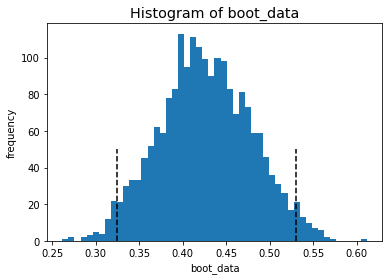

  0%|          | 0/2000 [00:00<?, ?it/s]

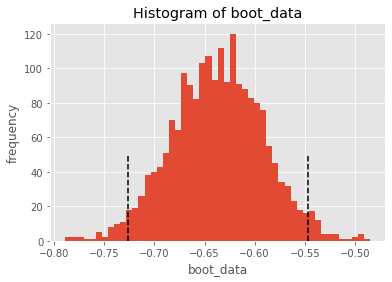

  0%|          | 0/2000 [00:00<?, ?it/s]

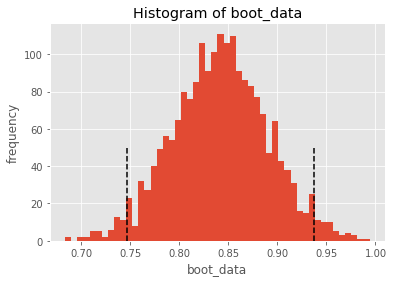

  0%|          | 0/2000 [00:00<?, ?it/s]

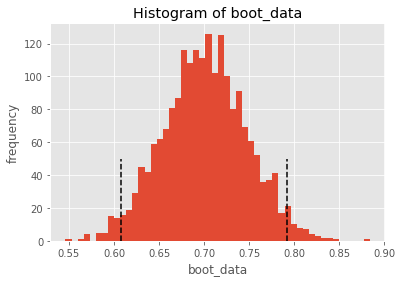

  0%|          | 0/2000 [00:00<?, ?it/s]

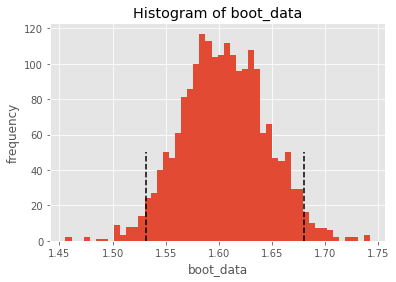

  0%|          | 0/2000 [00:00<?, ?it/s]

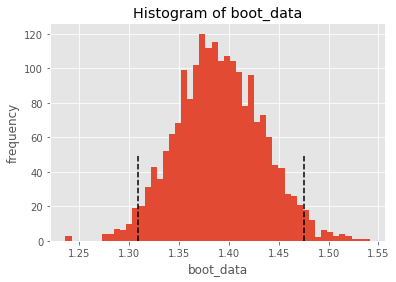

  0%|          | 0/2000 [00:00<?, ?it/s]

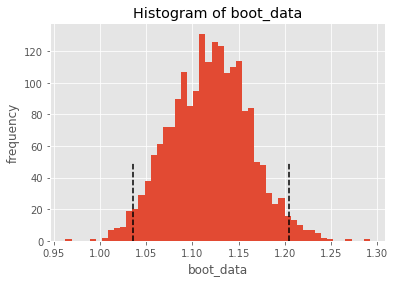

  0%|          | 0/2000 [00:00<?, ?it/s]

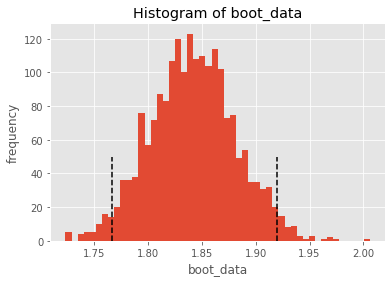

  0%|          | 0/2000 [00:00<?, ?it/s]

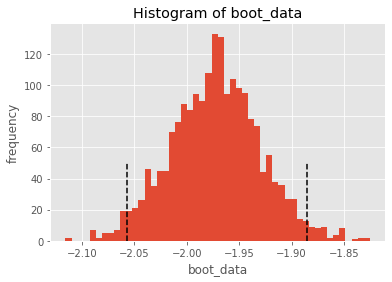

  0%|          | 0/2000 [00:00<?, ?it/s]

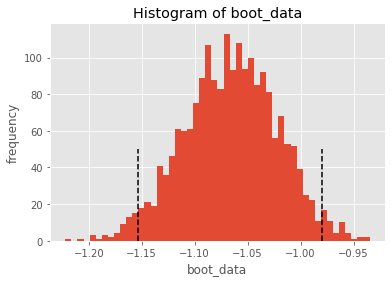

  0%|          | 0/2000 [00:00<?, ?it/s]

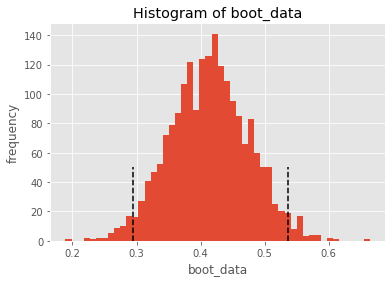

  0%|          | 0/2000 [00:00<?, ?it/s]

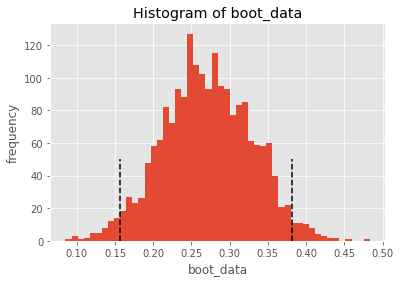

  0%|          | 0/2000 [00:00<?, ?it/s]

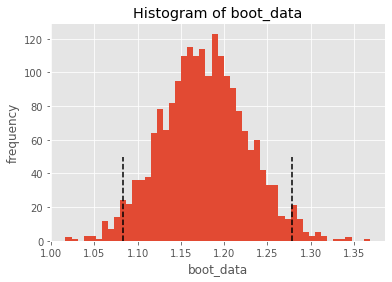

  0%|          | 0/2000 [00:00<?, ?it/s]

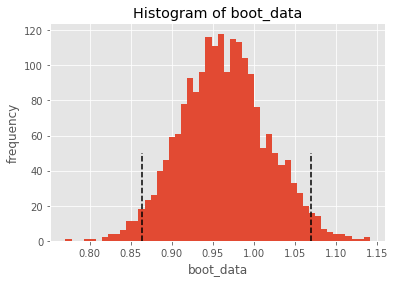

  0%|          | 0/2000 [00:00<?, ?it/s]

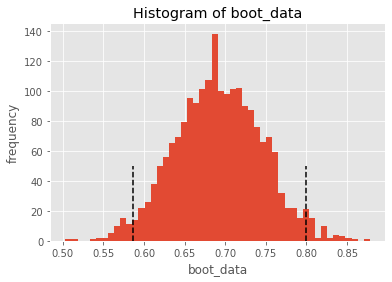

  0%|          | 0/2000 [00:00<?, ?it/s]

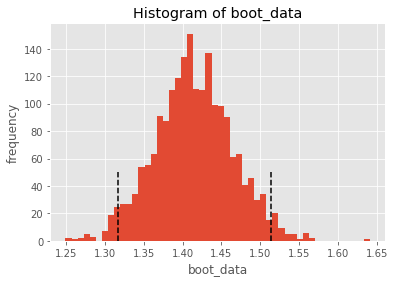

  0%|          | 0/2000 [00:00<?, ?it/s]

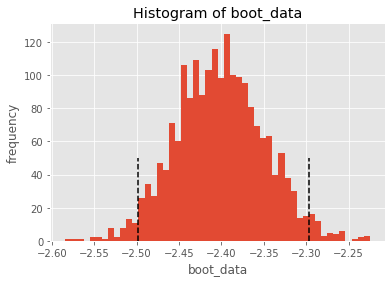

  0%|          | 0/2000 [00:00<?, ?it/s]

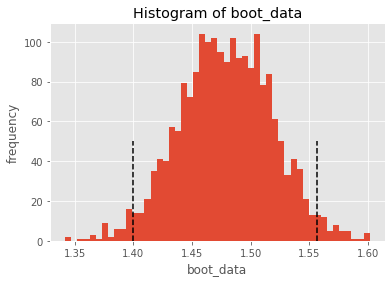

  0%|          | 0/2000 [00:00<?, ?it/s]

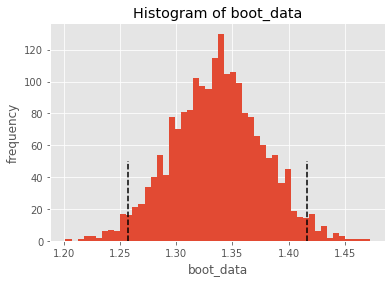

  0%|          | 0/2000 [00:00<?, ?it/s]

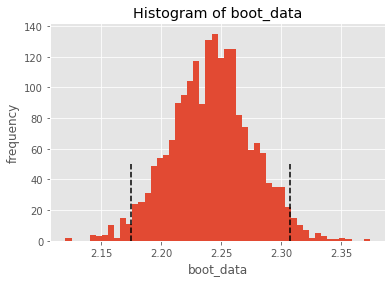

  0%|          | 0/2000 [00:00<?, ?it/s]

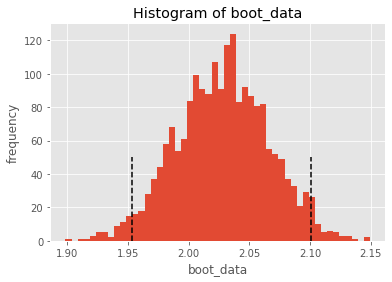

  0%|          | 0/2000 [00:00<?, ?it/s]

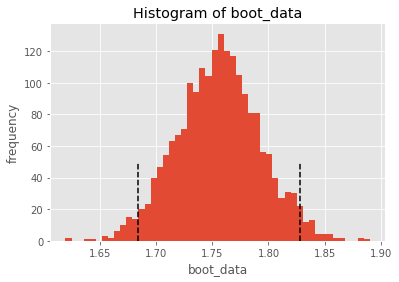

  0%|          | 0/2000 [00:00<?, ?it/s]

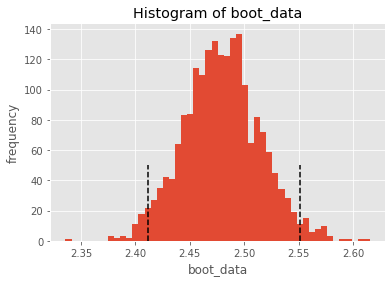

  0%|          | 0/2000 [00:00<?, ?it/s]

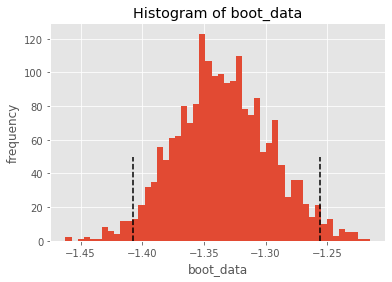

  0%|          | 0/2000 [00:00<?, ?it/s]

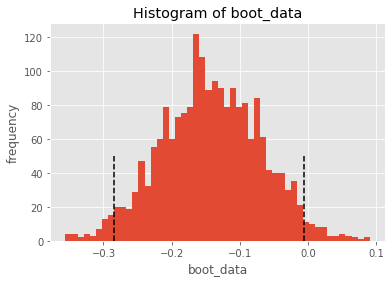

  0%|          | 0/2000 [00:00<?, ?it/s]

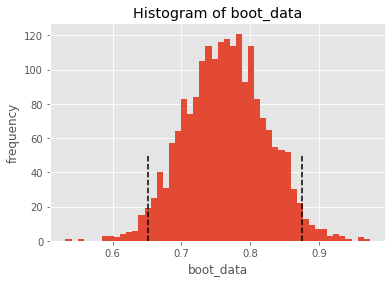

  0%|          | 0/2000 [00:00<?, ?it/s]

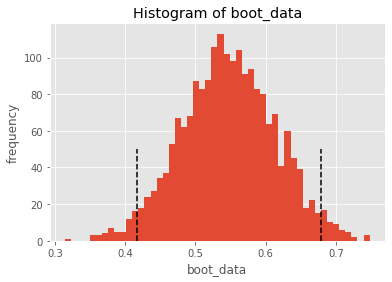

  0%|          | 0/2000 [00:00<?, ?it/s]

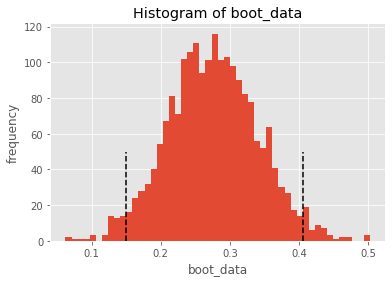

  0%|          | 0/2000 [00:00<?, ?it/s]

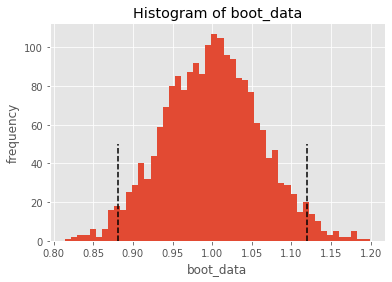

  0%|          | 0/2000 [00:00<?, ?it/s]

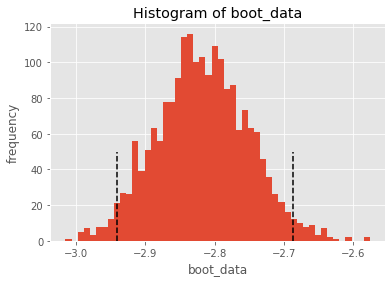

  0%|          | 0/2000 [00:00<?, ?it/s]

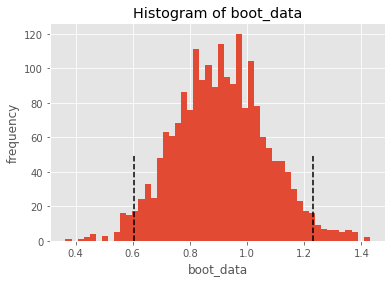

  0%|          | 0/2000 [00:00<?, ?it/s]

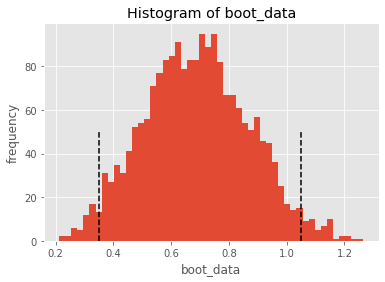

  0%|          | 0/2000 [00:00<?, ?it/s]

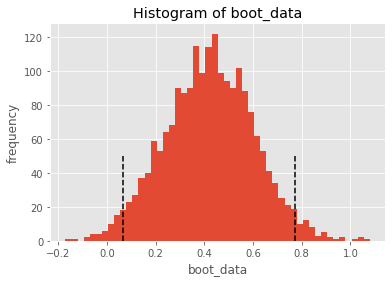

  0%|          | 0/2000 [00:00<?, ?it/s]

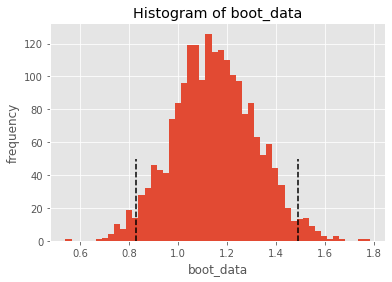

  0%|          | 0/2000 [00:00<?, ?it/s]

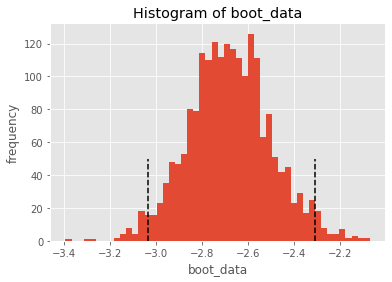

  0%|          | 0/2000 [00:00<?, ?it/s]

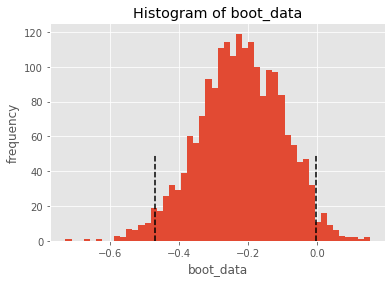

  0%|          | 0/2000 [00:00<?, ?it/s]

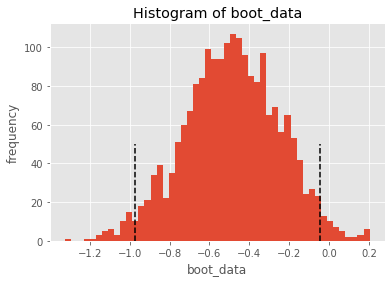

  0%|          | 0/2000 [00:00<?, ?it/s]

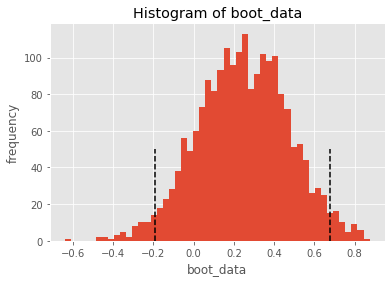

  0%|          | 0/2000 [00:00<?, ?it/s]

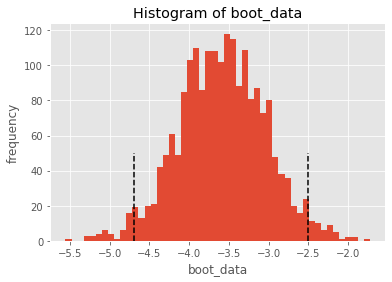

  0%|          | 0/2000 [00:00<?, ?it/s]

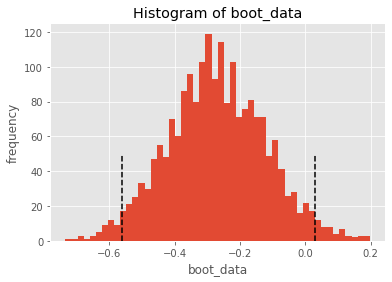

  0%|          | 0/2000 [00:00<?, ?it/s]

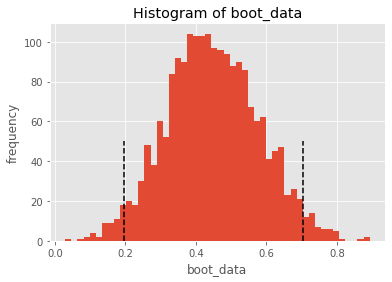

  0%|          | 0/2000 [00:00<?, ?it/s]

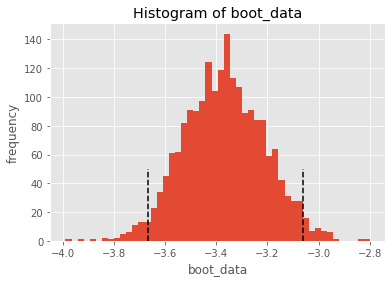

  0%|          | 0/2000 [00:00<?, ?it/s]

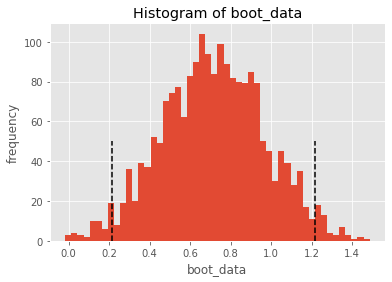

  0%|          | 0/2000 [00:00<?, ?it/s]

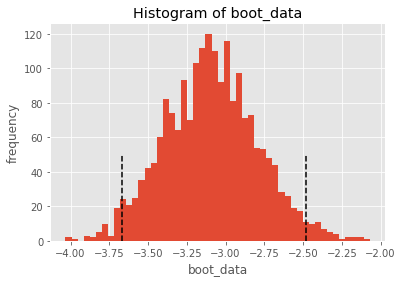

  0%|          | 0/2000 [00:00<?, ?it/s]

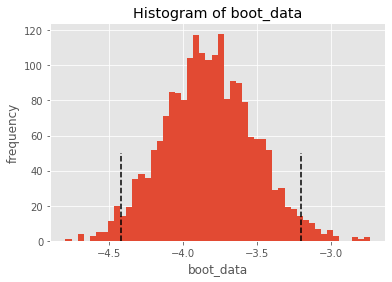

In [45]:
#  Посчитаем p-value Бутстрапом
# при уровень значимости 0.95

os = ['11', '10', '12', '9', '8.0.0', '6.0.1', '8.1.0', '7.0', '7.1.2', '7.1.1']
compare_pi = np.zeros((10,10)) # сохраним p-value

for i in range(len(os)):
    os_to_compare1 = os[i]
    df1 = data.query('os_version == @os_to_compare1').ecpm    
    for j in range(i+1,len(os)):
        os_to_compare2 = os[j]
        df2 = data.query('os_version == @os_to_compare2').ecpm
        boot_data = get_bootstrap(df1, df2)
        compare_pi[i][j] = boot_data["p_value"]



In [46]:
# посмотрим на результаты
compare_mean_ecpm_pi = pd.DataFrame(compare_pi, 
                    index=pd.Series(['11', '10', '12', '9', '8.0.0', '6.0.1', '8.1.0', '7.0', '7.1.2', '7.1.1']), 
                     columns=pd.Series(['11', '10', '12', '9', '8.0.0', '6.0.1', '8.1.0', '7.0', '7.1.2', '7.1.1']))
compare_mean_ecpm_pi

,11,10,12,9,8.0.0,6.0.1,8.1.0,7.0,7.1.2,7.1.1
11,0.0,6.561606e-16,1.610119e-44,6.493199e-68,1.859373e-51,0.000000e+00,1.751955e-227,9.485158e-150,0.000000e+00,0.000000e+00
10,0.0,0.000000e+00,1.465510e-130,1.668169e-11,3.209901e-06,1.355145e-125,2.718054e-74,2.287880e-38,7.329678e-176,0.000000e+00
12,0.0,0.000000e+00,0.000000e+00,5.668111e-306,1.075842e-243,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.925366e-263
9,0.0,0.000000e+00,0.000000e+00,0.000000e+00,5.115099e-02,5.500858e-38,2.327441e-16,1.858290e-05,9.250568e-61,0.000000e+00
8.0.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.448185e-08,1.442440e-04,2.029527e-02,6.106136e-12,2.494475e-50
6.0.1,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.872196e-02,3.998744e-02,2.724836e-01,5.294321e-11
8.1.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,6.966816e-02,5.948396e-04,4.368048e-102
7.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.628567e-03,5.475740e-25
7.1.2,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.293875e-35
7.1.1,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


In [47]:
compare_mean_ecpm_pi > 0.05

,11,10,12,9,8.0.0,6.0.1,8.1.0,7.0,7.1.2,7.1.1
11,False,False,False,False,False,False,False,False,False,False
10,False,False,False,False,False,False,False,False,False,False
12,False,False,False,False,False,False,False,False,False,False
9,False,False,False,False,True,False,False,False,False,False
8.0.0,False,False,False,False,False,False,False,False,False,False
6.0.1,False,False,False,False,False,False,True,False,True,False
8.1.0,False,False,False,False,False,False,False,True,False,False
7.0,False,False,False,False,False,False,False,False,False,False
7.1.2,False,False,False,False,False,False,False,False,False,False
7.1.1,False,False,False,False,False,False,False,False,False,False


Отклоняем нулевую гипотезу, о равенстве средних eCPM-ов по версиям ОС,  для всех кроме 2-х случаев (6.0.1 и 8.1.0) и (8.1.0 и 7.0).

Вывод: Средние значения статистически НЕ различаются только для (6.0.1 и 8.1.0) и (8.1.0 и 7.0), в остальных случаях различия статистически значимые.

Самое большое среднее значение eCPM у андроида версии 7.1.1 - статистически значимый результат.

# 1.с Cуммарные доходы по версиям ОС

In [48]:
sum_rev_by_os = data.groupby(['os_version'], as_index=False).agg({'revenue':'sum'}).sort_values(by = 'revenue', ascending=False)

fig = px.histogram(sum_rev_by_os, x="revenue", y='os_version' ,nbins=10, text_auto=True, 
                   title="Распределение суммарного дохода по версиям ОС")

fig.show()

Несмотря на то, что средний eCPM у ОС '7.1.1' выше чем у остальных (4.6), у него самый маленький суммарный доход.
Наибольший суммарный доход у ОС версии '12' при среднем eCPM (3.3). Следовательно пользователи с версии ОС '12' приносят больше прибыли.

# 1.с Cуммарные доходы по городам

In [49]:
sum_rev_by_city = data.groupby(['city'], as_index=False)\
                    .agg({'revenue':'sum'})\
                    .sort_values(by = 'revenue', ascending=False)

fig = px.histogram(sum_rev_by_city.head(10), x='city', y="revenue" ,nbins=10, text_auto=True, 
                   title="Распределение суммарного дохода по городам")

fig.show()

Больше всего дохода приносят пользователи из США, а именно из Нью-Йорка, Индианаполиса и Хьюстона.

# 2. Выводы

- В данных много пропущенных значений, а именно в profile_id, operator_name и city. Число пропусков составляет порядка 40% от всех данных, это очень много. Для лучших результатов исследования необходимо их восстановить или заполнить, например частотными значениями. Однако,  в условиях сжатых сроков, проведем грубую оценку по "цельным данным". 

- Количество уникальных пользователей - 2841
- Страны в которых используется приложение 'US', 'GB', 'MX', 'CA' 
- Временной период за который представленны данные: 2022-01-29 - 2022-02-07

- типы устройств В датасете большая часть устройств относится к телефонам. Меньшая к планшетам. Среди производителей отсутствует компания Apple, значит все устройства работают на ОС Android.

- Больше всего показов пришлось на полноэкранную рекламу (int). Меньше всего пришлось на видео, которое юзер смотрит по желанию (rv).Мы видим, что на телефоне больше всего показывают полноэкранную рекламу (int), а меньше рекламу за бонусы. Однако на планшетах чаще всего показывают баннерную рекламу, и меньше всего рекламу за бонусы.

- Распределение средних eCPM-ов юзеров распределены  не нормально
- В среднем, самые высокие eCPM-ы у Ронерт-Парк 297.6, Лейк Уорт 219.3 и Ла-Кроссе 216.9.
- В среднем самые высокие eCPM-ы у ОС 7.1.1 (4.6), у ОС 12 (3.3), у ОС 11 (2.67)

- Средние значения eCPM-ов по версиям ОС статистически НЕ различаются только для (6.0.1 и 8.1.0) и (8.1.0 и 7.0), в остальных случаях различия статистически значимые. Самое большое среднее значение eCPM у андроида версии 7.1.1 - статистически значимый результат.

- Несмотря на то, что средний eCPM у ОС '7.1.1' выше чем у остальных (4.6), у него самый маленький суммарный доход. Наибольший суммарный доход у ОС версии '12' при среднем eCPM (3.3). Следовательно пользователи с версии ОС '12' приносят больше прибыли.

- Больше всего дохода приносят пользователи из США, а именно из Нью-Йорка, Индианаполиса и Хьюстона.

- Следующим шагом в оаботе будет: 
        -- восстановление пропусков в данных
        -- анализ платформы (какая из платформ является прибыльней и др.)
        -- анализ показов рекламы в зависимости от игрового этапа

